# Prelim

In [571]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")
    

# Visualization

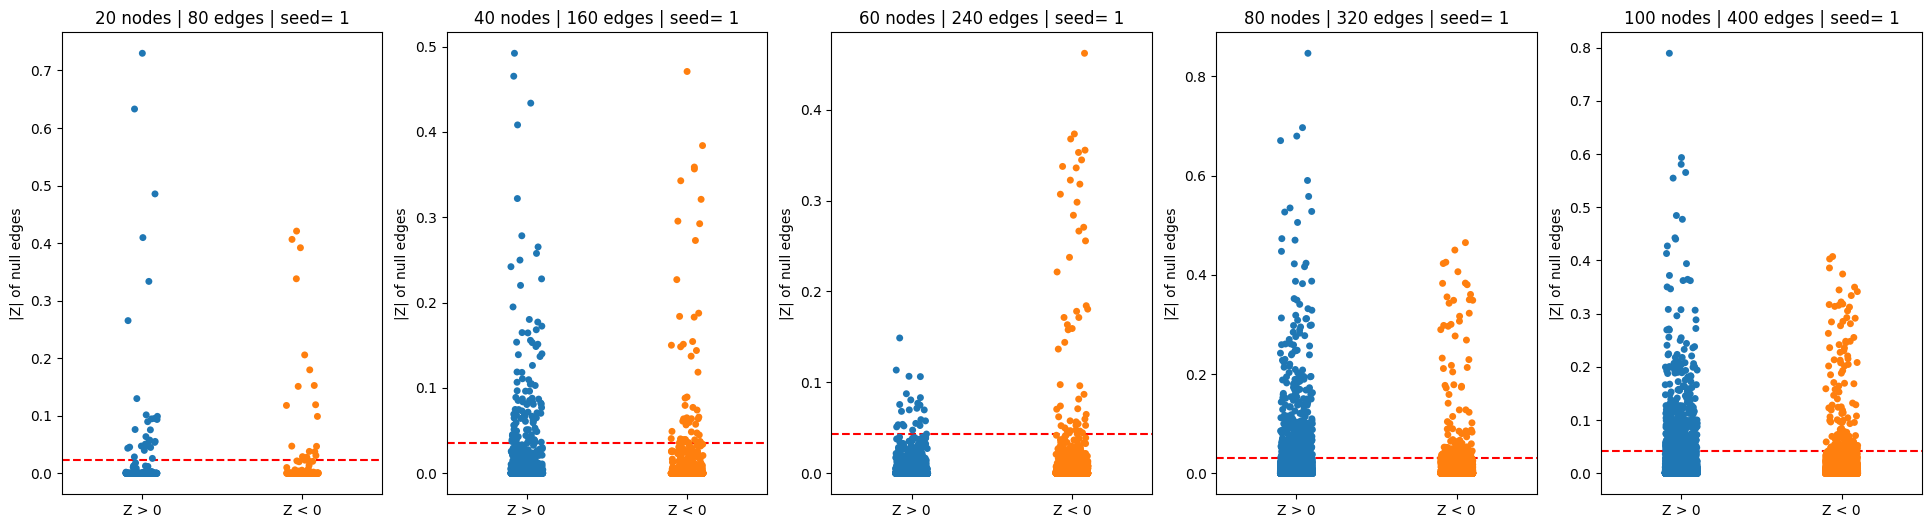

In [171]:
fig, axs = plt.subplots(1, 5, figsize=(24, 6))

n_nodes = 20
draw_strip(n_nodes, axs[0])

n_nodes = 40
draw_strip(n_nodes, axs[1])

n_nodes = 60
draw_strip(n_nodes, axs[2])

n_nodes = 80
draw_strip(n_nodes, axs[3])

n_nodes = 100
draw_strip(n_nodes, axs[4])


plt.show()

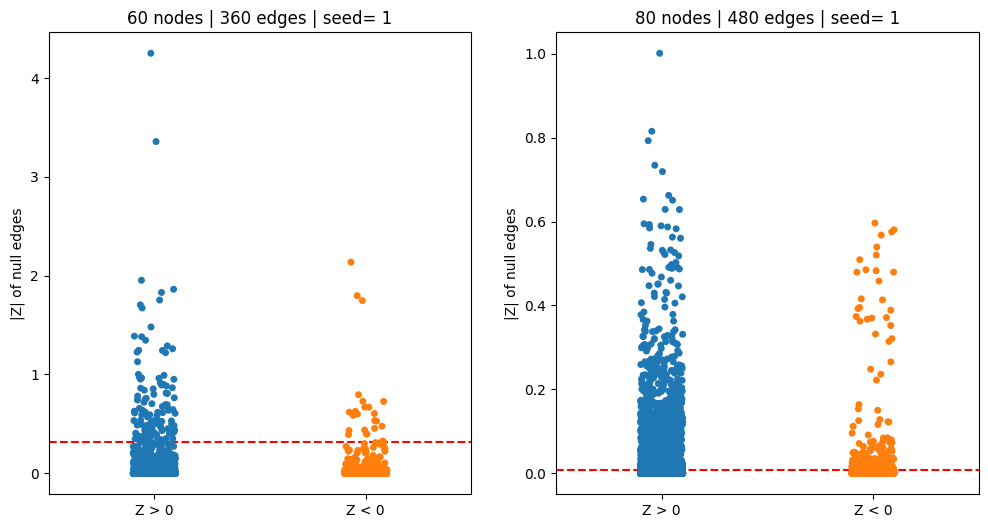

In [379]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
n_nodes = 60
draw_strip(n_nodes, axs[0], version='v38/v60_360', s0=6)

n_nodes = 80
draw_strip(n_nodes, axs[1], version='v38/v80_480', s0=6)


plt.show()

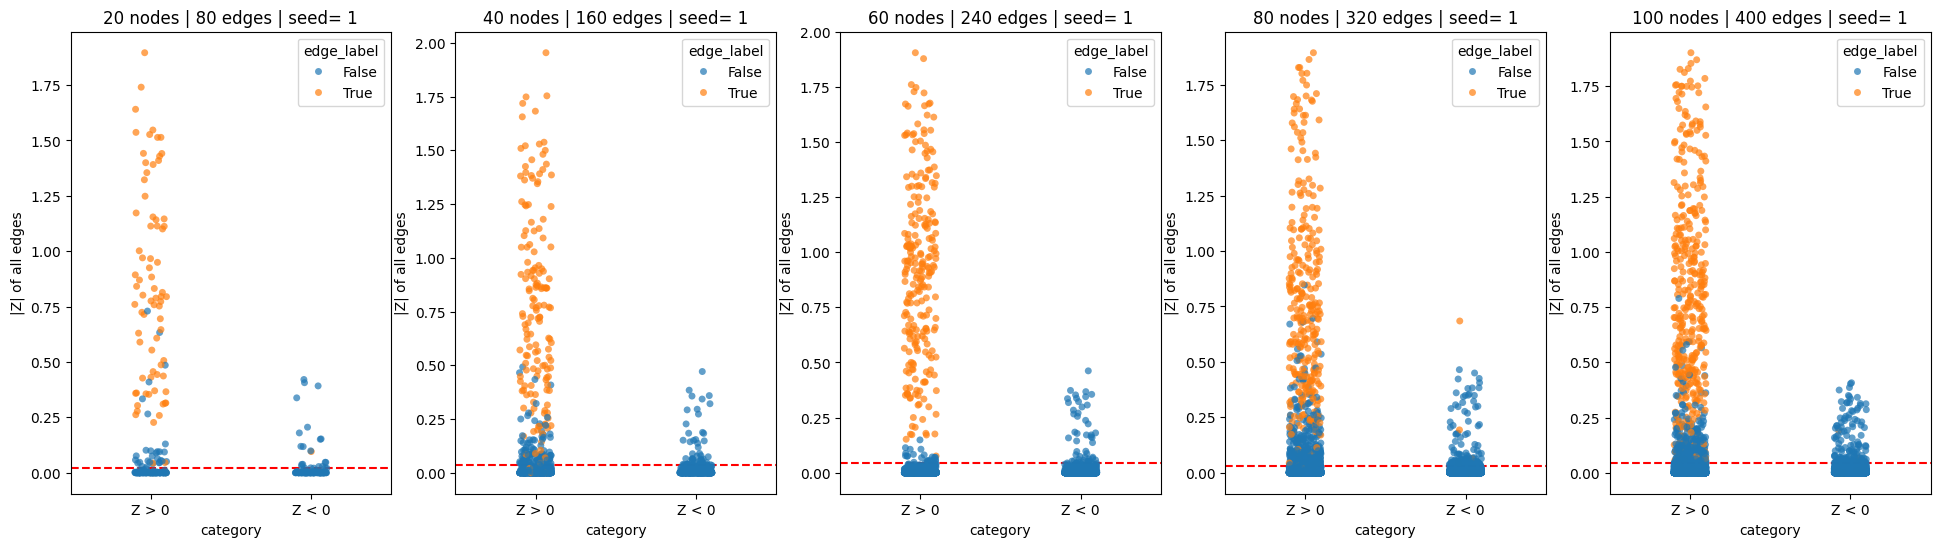

In [374]:
fig, axs = plt.subplots(1, 5, figsize=(24, 6))

n_nodes = 20
draw_strip(n_nodes, axs[0], only_null=False)

n_nodes = 40
draw_strip(n_nodes, axs[1], only_null=False)

n_nodes = 60
draw_strip(n_nodes, axs[2], only_null=False)

n_nodes = 80
draw_strip(n_nodes, axs[3], only_null=False)

n_nodes = 100
draw_strip(n_nodes, axs[4], only_null=False)


plt.show()

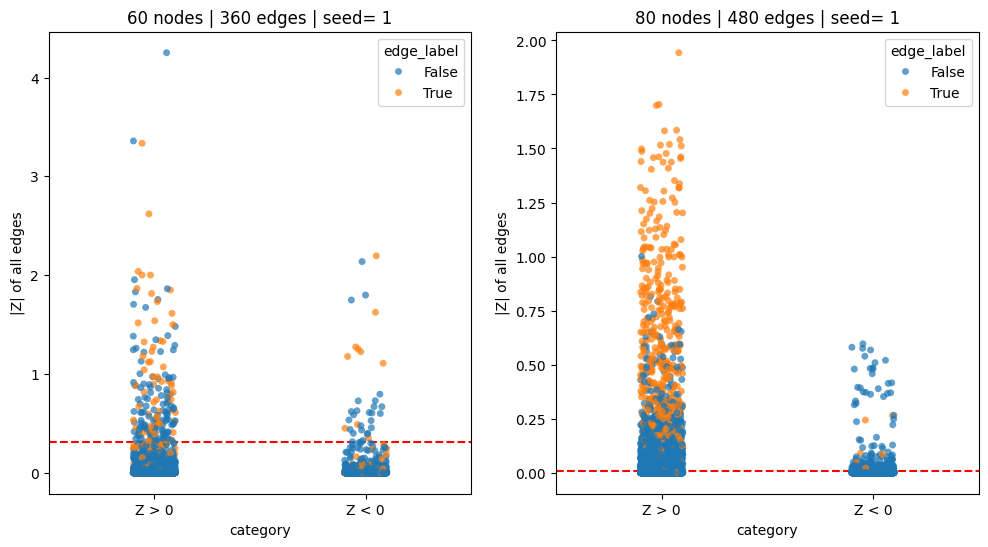

In [375]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
n_nodes = 60
draw_strip(n_nodes, axs[0], version='v38/v60_360', s0=6, only_null=False)

n_nodes = 80
draw_strip(n_nodes, axs[1], version='v38/v80_480', s0=6, only_null=False)


plt.show()

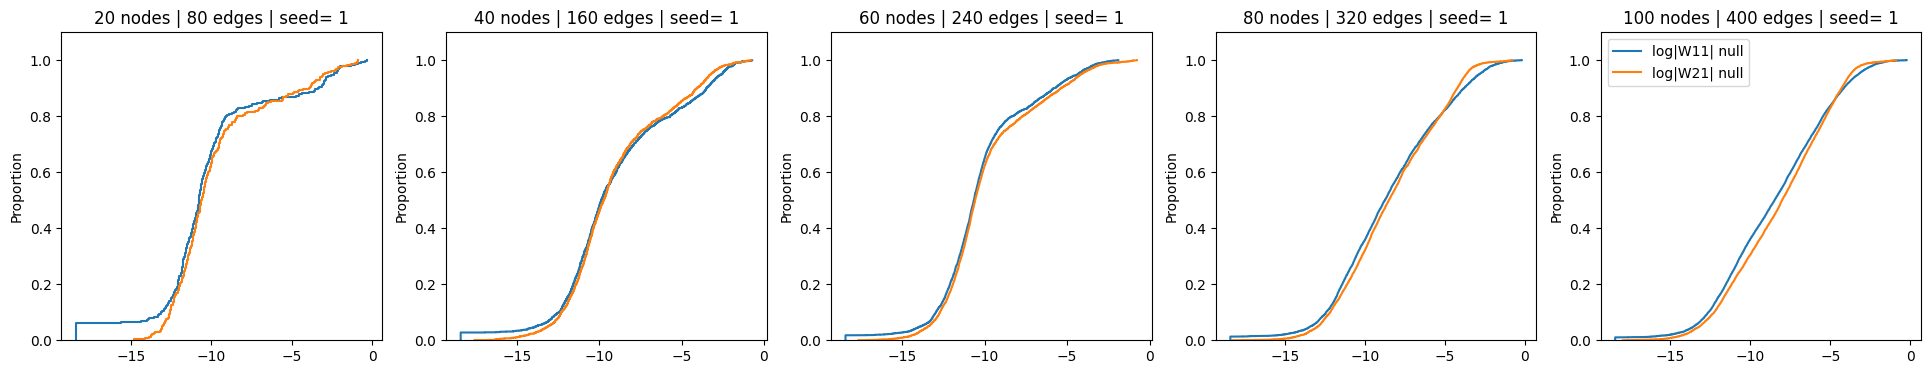

In [188]:
fig, axs = plt.subplots(1, 5, figsize=(24, 4))

n_nodes = 20
draw_ecdf(n_nodes, axs[0], True)

n_nodes = 40
draw_ecdf(n_nodes, axs[1], True)

n_nodes = 60
draw_ecdf(n_nodes, axs[2], True)

n_nodes = 80
draw_ecdf(n_nodes, axs[3], True)

n_nodes = 100
draw_ecdf(n_nodes, axs[4], True)

plt.legend()
plt.show()

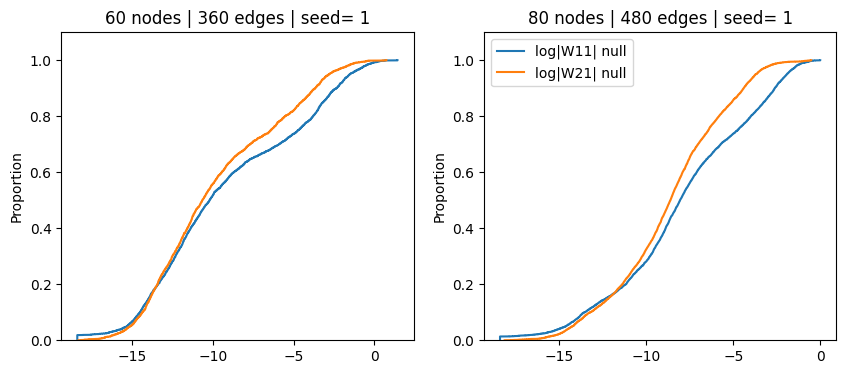

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

n_nodes = 60
draw_ecdf(n_nodes, axs[0], True, "v38/v60_360",  s0=6)

n_nodes = 80
draw_ecdf(n_nodes, axs[1], True, "v38/v80_480",  s0=6)

plt.legend()
plt.show()

# 80 nodes, 320 edges

In [646]:
X, B_true, W_est, W_true = load_data(n_nodes, 1, "v34/v80")
W11, W21 = get_block(W_est, n_nodes=80, index=11), get_block(W_est, n_nodes=80, index=21)
Z11_21 = get_Z(W_est, n_nodes=80)
mask = (Z11_21 > 0.5) & (~B_true)

## degree
* anomaly edgese have source nodes which have higher average out-degree
* edges with source nodes with high degree may NOT be anomaly edges.

### ground truth degree

In [210]:
np.where(mask)

(array([ 7, 11, 20, 32, 34, 36, 55, 78, 79, 79]),
 array([12, 43, 30, 25,  4, 17, 12, 49, 17, 65]))

In [691]:
B_true.sum(axis=1)[np.where(mask)[0]] # source node out-degree always large

array([ 7,  8,  4,  6,  8,  6,  4,  3, 10, 10])

In [692]:
B_true.sum(axis=0)[np.where(mask)[0]] # source nodes in-degree always small

array([1, 0, 3, 0, 0, 1, 0, 2, 1, 1])

In [236]:
B_true.sum(axis=1)[np.where(mask)[1]]

array([7, 6, 1, 5, 4, 3, 7, 5, 3, 7])

In [234]:
B_true.sum(axis=0)[np.where(mask)[1]]

array([4, 3, 3, 0, 5, 4, 4, 6, 4, 0])

In [429]:
B_true.sum(axis=1)

array([ 6,  1, 15,  4,  4,  3,  4,  7, 10,  4,  7,  8,  7,  6,  0,  3,  1,
        3,  6,  3,  4,  6,  0,  4,  4,  5,  1,  7,  0,  2,  1,  0,  6,  1,
        8,  0,  6,  3,  0,  6,  3,  0,  6,  6,  2,  4, 10,  4,  1,  5,  4,
        4,  8,  0,  4,  4,  4,  1,  0,  5,  0,  0,  8,  1,  9,  7,  0,  1,
        3,  5,  8,  9,  2,  3,  1,  1,  6,  2,  3, 10])

In [274]:
B_true.sum(axis=0)

array([ 2,  4,  2,  1,  5,  6,  3,  1,  3,  5,  0,  0,  4,  3,  7,  0,  8,
        4,  3,  3,  3,  0,  7,  0,  1,  0,  9,  2,  5,  6,  3,  4,  0,  2,
        0,  5,  1,  7, 11,  4,  2, 12,  4,  3,  7,  5,  1,  8,  5,  6,  3,
        6,  1,  7,  2,  0,  0, 10, 11,  9,  5,  5,  2,  8,  3,  0,  7,  9,
        4,  6,  5,  0,  0,  7,  9,  6,  2,  3,  2,  1])

### how about null edges with source nodes with high out-degree?
* edges with source nodes with high degree may not be anomaly edges.

In [381]:
mask1 = ~B_true.copy()
mask1[~(B_true.sum(axis=1) >= 11), :] = False
Z11_21[mask1].max()

0.46977003509417

In [384]:
np.abs(Z11_21[mask1]).mean()

0.020788225220687566

In [385]:
np.abs(Z11_21[mask1]).min()

1.7654167988159452e-06

### ground truth weight degree

In [418]:
W11_true = get_block(W_true, n_nodes=80, index=11)
np.abs(W11_true).sum(axis=1)[np.where(mask)[0]]

array([ 9.10036867, 11.89510616,  4.52961263,  7.68065424,  9.04059361,
        8.1060673 ,  4.41107032,  2.86757325, 13.03622018, 13.03622018])

In [421]:
np.abs(W11_true).sum(axis=0)[np.where(mask)[0]]

array([1.71332268, 0.        , 3.90795967, 0.        , 0.        ,
       1.16404502, 0.        , 2.77775442, 0.62850808, 0.62850808])

In [423]:
np.abs(W11_true).sum(axis=1)[np.where(mask)[1]]

array([6.86432675, 7.97362313, 0.77090327, 7.80189132, 5.65615142,
       4.65652465, 6.86432675, 7.55342622, 4.65652465, 6.73940641])

In [426]:
np.abs(W11_true).sum(axis=0)[np.where(mask)[1]]

array([6.52404327, 3.88258388, 2.03442327, 0.        , 5.786705  ,
       5.5776089 , 6.52404327, 8.25271047, 5.5776089 , 0.        ])

In [454]:
np.abs(W11_true).sum(axis=0)

array([ 2.57897732,  5.66220115,  2.36199825,  1.57239455,  5.786705  ,
        7.36381991,  3.50900148,  1.71332268,  2.41915992,  7.75868913,
        0.        ,  0.        ,  6.52404327,  4.14296329,  8.60414776,
        0.        , 11.50238948,  5.5776089 ,  4.37147657,  5.42335919,
        3.90795967,  0.        ,  7.68143502,  0.        ,  1.3723036 ,
        0.        , 11.12761369,  3.09425978,  6.80194399,  5.8150463 ,
        2.03442327,  3.62466282,  0.        ,  2.0880441 ,  0.        ,
        6.59756138,  1.16404502,  7.26682116, 15.58103042,  3.50258368,
        2.06092569, 12.9455281 ,  5.45993463,  3.88258388,  9.4087871 ,
        6.80954803,  0.63401236, 11.60913089,  5.78242955,  8.25271047,
        3.84203169,  8.60071321,  1.65899728,  9.04362797,  1.32380158,
        0.        ,  0.        , 12.6844682 , 13.48582654, 11.63843929,
        7.88697737,  5.76609308,  1.80884183,  9.53549794,  4.11782602,
        0.        ,  9.03229275, 12.17844504,  5.84482402,  7.39

In [430]:
np.abs(W11_true).sum(axis=1)

array([ 7.87738974,  0.97458848, 20.8760249 ,  5.59923957,  5.65615142,
        2.52182615,  4.59566506,  9.10036867, 12.13652105,  5.00443447,
        7.74809113, 11.89510616,  6.86432675,  7.60650774,  0.        ,
        4.58282755,  0.78706993,  4.65652465,  8.71851449,  3.57710617,
        4.52961263,  7.0258964 ,  0.        ,  4.66587543,  3.62840053,
        7.80189132,  1.26535986,  8.29704128,  0.        ,  1.70416041,
        0.77090327,  0.        ,  7.68065424,  0.97598795,  9.04059361,
        0.        ,  8.1060673 ,  3.75293661,  0.        ,  9.05775324,
        4.25382782,  0.        ,  8.97748399,  7.97362313,  1.59595059,
        3.66970633, 12.9507759 ,  4.21905348,  1.95397483,  7.55342622,
        3.75615167,  6.04642116, 10.0573197 ,  0.        ,  4.88654371,
        4.41107032,  4.13165667,  1.94444733,  0.        ,  8.7139578 ,
        0.        ,  0.        , 11.19304698,  0.86517247,  9.44425176,
        6.73940641,  0.        ,  1.37913153,  4.52133852,  6.29

### does all null edges with source nodes with high out weighted degree have anomaly knockoff statistics?

<Axes: >

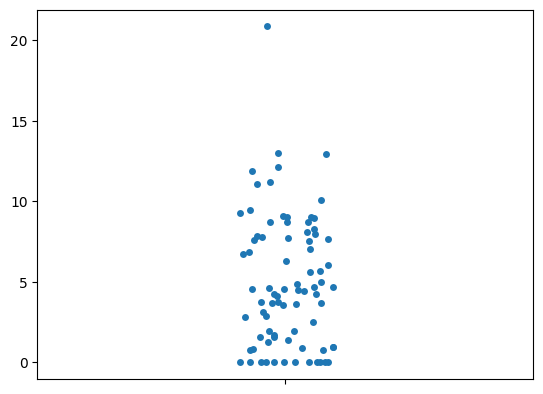

In [427]:
sns.stripplot(np.abs(W11_true).sum(axis=1))

In [461]:
a = np.array([
    [1, 1, 1],
    [2, 2, 2]
])

In [462]:
a.sum(axis=1)

array([3, 6])

In [431]:
mask1 = ~B_true.copy()
mask1[~(np.abs(W11_true).sum(axis=1) >= 10), :] = False
Z11_21[mask1].max()

0.5276097653787196

In [433]:
np.abs(Z11_21[mask1]).mean()

0.021848331295984586

### does all null edges with source nodes with low in weighted degree have anomaly knockoff statistics?

<Axes: >

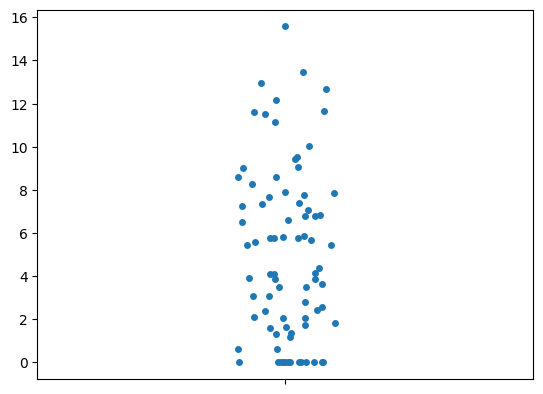

In [439]:
sns.stripplot(np.abs(W11_true).sum(axis=0))

In [482]:
mask1 = ~B_true.copy()
mask1[~(np.abs(W11_true).sum(axis=0) <= 2), :] = False
Z11_21[mask1].max()

0.8463352658805752

In [483]:
np.abs(Z11_21[mask1]).max()

0.8463352658805752

In [484]:
mask1 = np.full(B_true.shape, fill_value=False)
mask1[
    (np.abs(W11_true).sum(axis=1) >= 12),
    :
    ] = True
mask1[B_true] = False
Z11_21[mask1].max()

0.5276097653787196

<Axes: >

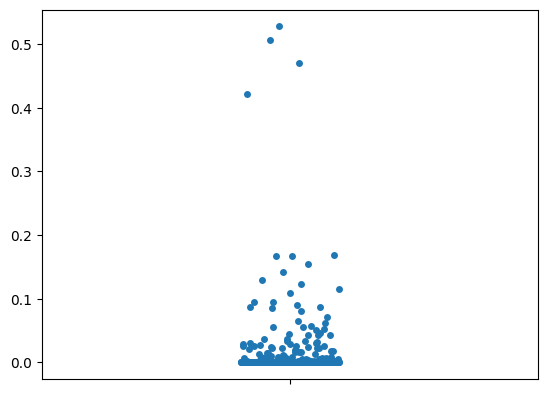

In [485]:
sns.stripplot(np.abs(Z11_21[mask1]))

In [478]:
Z11_21[~B_true].max()

0.8463352658805752

In [471]:
mask1.sum()

6002

### predicted weight

In [502]:
np.where(mask)

(array([], dtype=int64), array([], dtype=int64))

In [501]:
np.abs(W11).sum(axis=1)[np.where(mask)[0]]

array([], dtype=float64)

In [497]:
np.abs(W11).sum(axis=0)[np.where(mask)[1]]

array([4.02250424, 2.47171068, 2.62886139, 0.82801287, 5.10711608,
       5.76977911, 4.02250424, 4.83101376, 5.76977911, 0.86426352])

<Axes: >

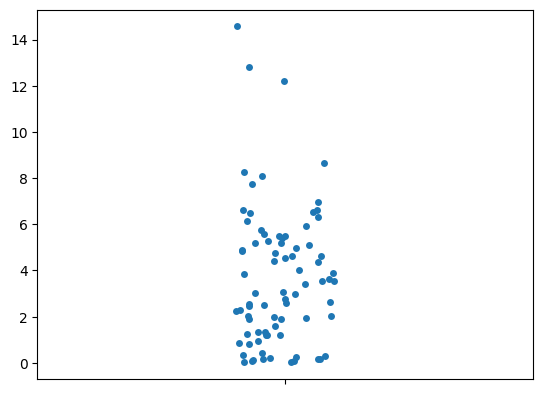

In [496]:
sns.stripplot(np.abs(W11).sum(axis=0))

<Axes: >

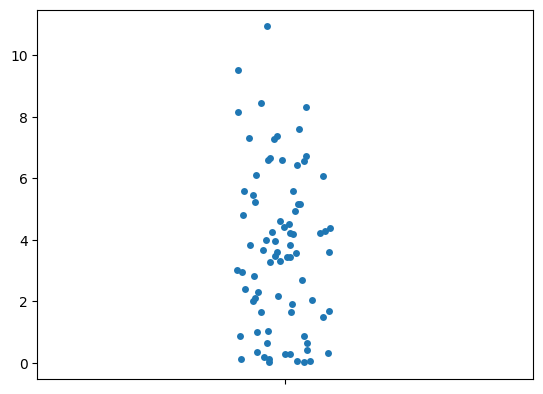

In [494]:
sns.stripplot(np.abs(W11).sum(axis=1))

In [535]:
mask1 = np.full(B_true.shape, fill_value=False)
a = np.where(np.abs(W11).sum(axis=1) >= 8)[0]
b = np.where(np.abs(W11).sum(axis=0) <= 2)[0]
index = list(product(a, b))
for i in index:
    mask1[i] = True
mask1[B_true] = False

<Axes: >

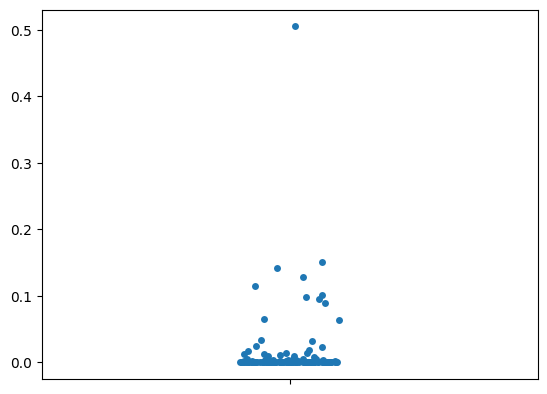

In [536]:
sns.stripplot(np.abs(Z11_21[mask1]))

In [529]:
mask1[index[0]]

False

In [528]:
len(index)

135

In [518]:
a

array([ 2,  8, 11, 36, 79])

In [519]:
b

array([ 3,  7, 10, 11, 13, 15, 20, 21, 23, 24, 25, 27, 32, 34, 36, 40, 46,
       52, 54, 55, 56, 62, 65, 71, 72, 76, 79])

In [520]:
from itertools import product

In [525]:
len()

135

## transitivity effect, k = 2
* anomaly edges have higher average transitivity effect
* but edges with high transitivity effect (such as 3 in this case) are mostly NOT anomaly edges.

In [387]:
W_est_pow = np.linalg.matrix_power(W_est, 2)
W11_pow = get_block(W_est_pow, n_nodes=80, index=11)

In [388]:
np.abs(W11_pow)[mask].mean()

0.21927454317613065

In [389]:
np.abs(W11_pow)[mask]

array([0.52722447, 0.0981652 , 0.19321107, 0.02357453, 0.01616927,
       0.09659448, 0.43878278, 0.65485347, 0.09599035, 0.04817981])

In [390]:
np.abs(W11_pow[~B_true]).mean()

0.07298679633100369

<Axes: >

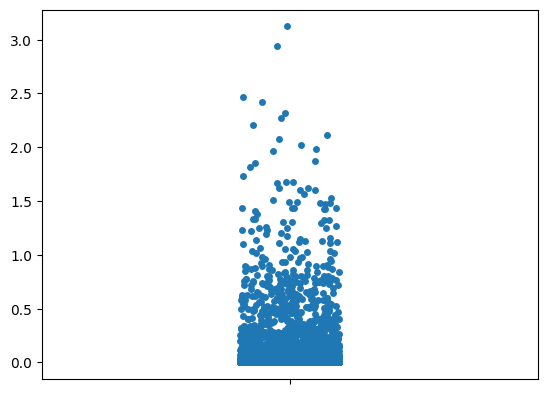

In [391]:
sns.stripplot(np.abs(W11_pow[~B_true]))

### how about those edges with high average transitive effect?

In [392]:
mask1 = (np.abs(W11_pow) > 1.0) & (~B_true)

<Axes: >

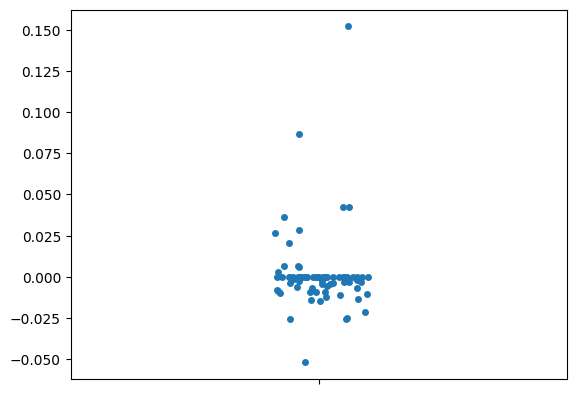

In [393]:
sns.stripplot(Z11_21[mask1])

### transitive effect, k is more

In [394]:
W_est_pow = np.linalg.matrix_power(W_est, 2) + np.linalg.matrix_power(W_est, 3) + np.linalg.matrix_power(W_est, 4)
W11_pow = get_block(W_est_pow, n_nodes=80, index=11)

In [395]:
np.abs(W11_pow)[mask].mean()

0.3121182603431104

In [396]:
np.abs(W11_pow)[mask]

array([0.78085818, 0.03054972, 0.23740239, 0.09814044, 0.02820009,
       0.13139661, 0.49388155, 0.74765528, 0.52397063, 0.04912771])

In [397]:
np.abs(W11_pow[~B_true]).mean()

0.21656008808832386

<Axes: >

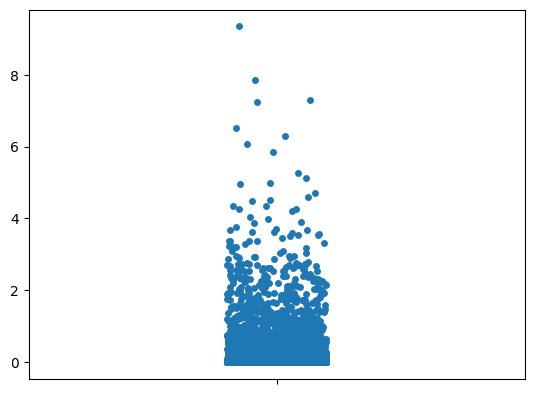

In [398]:
sns.stripplot(np.abs(W11_pow[~B_true]))

<Axes: >

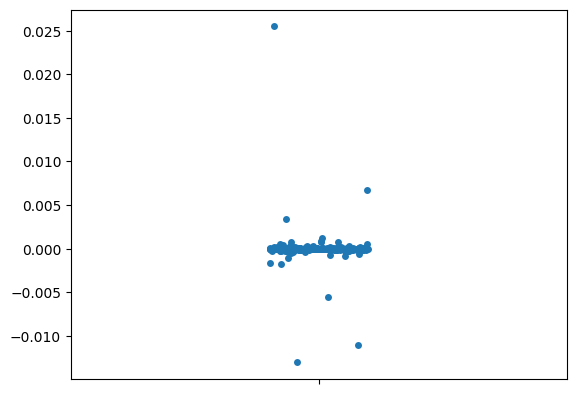

In [399]:
# how about those edges with high average transitive effect?
mask1 = (np.abs(W11_pow) < 1e-4) & (~B_true)
sns.stripplot(Z11_21[mask1])

## local density

In [540]:
g = nx.DiGraph(B_true)

In [551]:
new_mask = np.stack(np.where(mask)).T

In [552]:
new_mask

array([[ 7, 12],
       [11, 43],
       [20, 30],
       [32, 25],
       [34,  4],
       [36, 17],
       [55, 12],
       [78, 49],
       [79, 17],
       [79, 65]])

In [553]:
set(g.neighbors(new_mask[0, 0])).intersection(g.neighbors(new_mask[0, 1]))

{13}

In [575]:
set(g.neighbors(12)).intersection(g.neighbors(13))

set()

In [588]:
set(np.where(B_true[7, :])[0]).intersection(np.where(B_true[:, 12])[0])

set()

In [589]:
np.where(B_true[:, 12])[0]

array([ 0,  2, 21, 25])

In [590]:
np.where(B_true[7, :])

(array([13, 19, 30, 40, 41, 57, 58]),)

In [598]:
W_true[25, 12]

-1.8440724980863337

In [599]:
W11[25, 12]

-0.8781937328613412

In [597]:
W11[25, 12]

-0.8781937328613412

In [608]:
# true values
np.abs((X @ W_true)[:, 12] - X[:, 12]).mean()

0.7925502652719213

In [610]:
_W11 = W11.copy()
_W11[~B_true] = 0.
np.abs((X @ _W11)[:, 12] - X[:, 12]).mean()

2.9627907005831644

In [611]:
_W11 = W11.copy()
np.abs((X @ _W11)[:, 12] - X[:, 12]).mean()

2.4200094266185004

In [612]:
B_true.sum(axis=0)

array([ 2,  4,  2,  1,  5,  6,  3,  1,  3,  5,  0,  0,  4,  3,  7,  0,  8,
        4,  3,  3,  3,  0,  7,  0,  1,  0,  9,  2,  5,  6,  3,  4,  0,  2,
        0,  5,  1,  7, 11,  4,  2, 12,  4,  3,  7,  5,  1,  8,  5,  6,  3,
        6,  1,  7,  2,  0,  0, 10, 11,  9,  5,  5,  2,  8,  3,  0,  7,  9,
        4,  6,  5,  0,  0,  7,  9,  6,  2,  3,  2,  1])

In [618]:
B_true[:, np.where(mask)[1]].sum(axis=0)

array([4, 3, 3, 0, 5, 4, 4, 6, 4, 0])

In [632]:
np.abs(X[:, np.where(mask)[1]]).mean(axis=0)

array([ 4.46548435, 36.01797094,  3.61313519,  0.80108001,  9.1616154 ,
       14.10450033,  4.46548435,  3.70575652, 14.10450033,  0.80011899])

<Axes: >

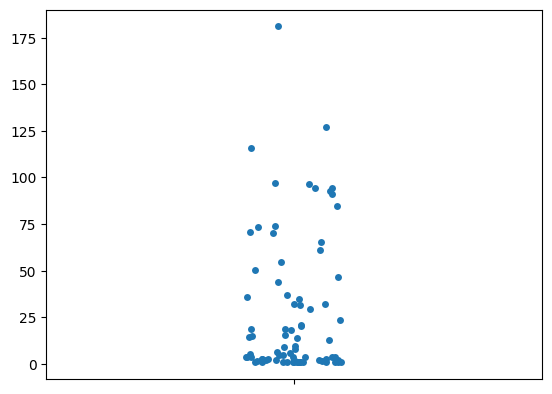

In [631]:
sns.stripplot(np.abs(X).mean(axis=0))

In [638]:
np.abs(W_true[:, np.where(mask)[1]]).mean(axis=0)

array([0.08155054, 0.0485323 , 0.02543029, 0.        , 0.07233381,
       0.06972011, 0.08155054, 0.10315888, 0.06972011, 0.        ])

<Axes: >

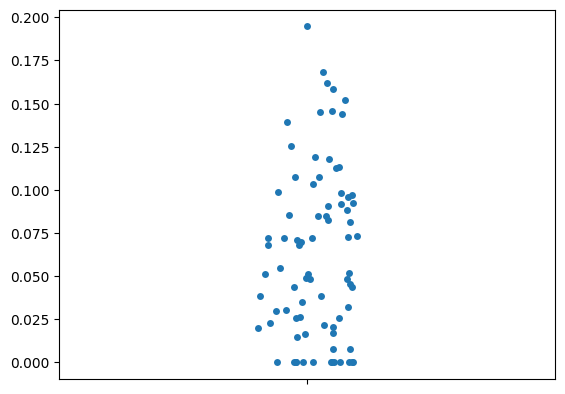

In [639]:
sns.stripplot(np.abs(W_true).mean(axis=0))

In [661]:
np.abs(W_true[:, np.where(mask)[1]]).sum(axis=0)

array([6.52404327, 3.88258388, 2.03442327, 0.        , 5.786705  ,
       5.5776089 , 6.52404327, 8.25271047, 5.5776089 , 0.        ])

<Axes: >

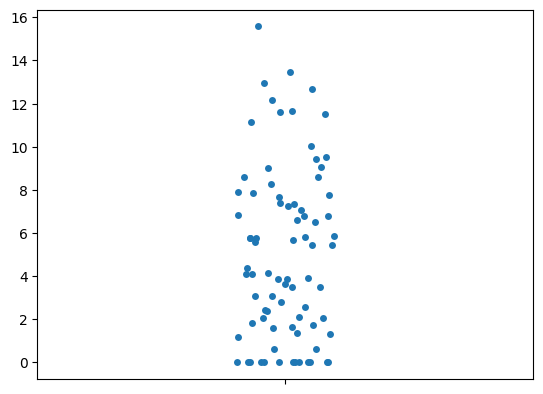

In [662]:
sns.stripplot(np.abs(W_true).sum(axis=0))

In [663]:
np.abs(W_true[:, np.where(mask)[1]]).std(axis=0)

array([0.35800741, 0.26483459, 0.13533353, 0.        , 0.29835786,
       0.30744989, 0.35800741, 0.37324234, 0.30744989, 0.        ])

<Axes: >

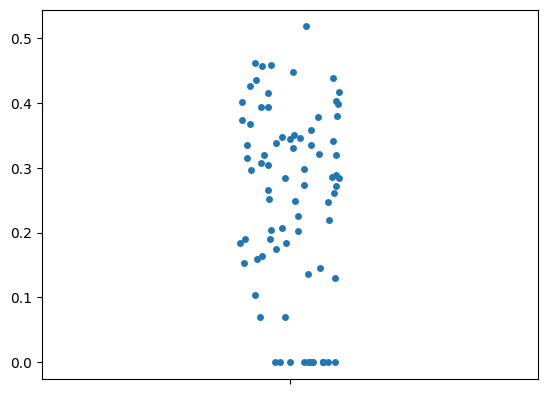

In [664]:
sns.stripplot(np.abs(W_true).std(axis=0))

In [667]:
mask1 = (np.abs(W_true).std(axis=0) < 0.38) & (np.abs(W_true).std(axis=0) > 0.25)

In [668]:
mask1.shape

(80,)

In [671]:
np.where(B_true[7, :])

(array([13, 19, 30, 40, 41, 57, 58]),)

In [682]:
mask1 = (B_true.sum(axis=0) >= 4) & (B_true.sum(axis=1) >= 4)

In [685]:
_W11 = W11.copy()

In [686]:
_W11[B_true] = 0.

In [687]:
np._W11[mask1, :]

array([[ 8.93470338e-05,  3.93084085e-03,  3.02355108e-04,
        -1.65468691e-05,  0.00000000e+00, -6.86066254e-04,
         5.68382558e-05,  3.74112585e-04, -3.83507126e-04,
         1.12186102e-01,  1.62819765e-04, -1.98566041e-05,
         9.05433417e-05,  4.07522953e-04,  3.61036476e-02,
        -5.93479471e-04, -6.63690425e-02, -6.99639104e-03,
         1.37323289e-05,  1.12871379e-02,  5.25089615e-04,
        -3.25966791e-04,  2.77095958e-05,  4.77237555e-05,
        -6.22517768e-05, -1.40978815e-05,  0.00000000e+00,
         2.16499767e-04, -1.08384276e-05,  5.08083834e-02,
         1.42326736e-04,  3.37168530e-05, -2.47976073e-04,
        -5.67545779e-06, -6.89447924e-05,  0.00000000e+00,
        -1.35931585e-05, -1.40764226e-01,  9.52007693e-03,
        -7.75731588e-04,  5.17464243e-04, -3.41751726e-05,
        -4.08877976e-03, -1.15897157e-01,  7.58948499e-05,
        -3.04884193e-04, -2.89860348e-04,  9.59107222e-02,
         3.38151074e-06,  7.32979315e-07, -1.46201898e-0

(80,)

In [675]:
B_true.sum(axis=1)

array([ 6,  1, 15,  4,  4,  3,  4,  7, 10,  4,  7,  8,  7,  6,  0,  3,  1,
        3,  6,  3,  4,  6,  0,  4,  4,  5,  1,  7,  0,  2,  1,  0,  6,  1,
        8,  0,  6,  3,  0,  6,  3,  0,  6,  6,  2,  4, 10,  4,  1,  5,  4,
        4,  8,  0,  4,  4,  4,  1,  0,  5,  0,  0,  8,  1,  9,  7,  0,  1,
        3,  5,  8,  9,  2,  3,  1,  1,  6,  2,  3, 10])

In [650]:
np.abs(W_true[:, np.where(mask)[1]]).sum(0)

array([6.52404327, 3.88258388, 2.03442327, 0.        , 5.786705  ,
       5.5776089 , 6.52404327, 8.25271047, 5.5776089 , 0.        ])

In [ ]:
B_true

In [659]:
np.abs(W_true).sum(0)

array([ 2.57897732,  5.66220115,  2.36199825,  1.57239455,  5.786705  ,
        7.36381991,  3.50900148,  1.71332268,  2.41915992,  7.75868913,
        0.        ,  0.        ,  6.52404327,  4.14296329,  8.60414776,
        0.        , 11.50238948,  5.5776089 ,  4.37147657,  5.42335919,
        3.90795967,  0.        ,  7.68143502,  0.        ,  1.3723036 ,
        0.        , 11.12761369,  3.09425978,  6.80194399,  5.8150463 ,
        2.03442327,  3.62466282,  0.        ,  2.0880441 ,  0.        ,
        6.59756138,  1.16404502,  7.26682116, 15.58103042,  3.50258368,
        2.06092569, 12.9455281 ,  5.45993463,  3.88258388,  9.4087871 ,
        6.80954803,  0.63401236, 11.60913089,  5.78242955,  8.25271047,
        3.84203169,  8.60071321,  1.65899728,  9.04362797,  1.32380158,
        0.        ,  0.        , 12.6844682 , 13.48582654, 11.63843929,
        7.88697737,  5.76609308,  1.80884183,  9.53549794,  4.11782602,
        0.        ,  9.03229275, 12.17844504,  5.84482402,  7.39